In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [188]:
df = pd.read_csv('../data/anime.csv')

In [189]:
df.drop(labels=['Name',"English name","Japanese name",'Aired','Producers','Licensors','Duration','Members','Watching','On-Hold'], axis='columns', inplace=True)

In [ ]:
df.info()

In [191]:
numeric_cols = [
    'Score', 'Episodes', 'Ranked',
    'Score-10','Score-9','Score-8','Score-7','Score-6',
    'Score-5','Score-4','Score-3','Score-2','Score-1'
]

In [192]:
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [193]:
print(df[numeric_cols].isna().sum())

Score       5141
Episodes     516
Ranked      1762
Score-10     437
Score-9     3167
Score-8     1371
Score-7      503
Score-6      511
Score-5      584
Score-4      977
Score-3     1307
Score-2     1597
Score-1      459
dtype: int64


In [194]:
df["Episodes"] =df['Episodes'].fillna(0)

In [195]:
score_cols = ['Score-10','Score-9','Score-8','Score-7','Score-6',
              'Score-5','Score-4','Score-3','Score-2','Score-1']
df[score_cols] = df[score_cols].fillna(0)

In [ ]:
print(df[numeric_cols].isna().sum())

In [197]:
cat = df.select_dtypes(include='O').keys()

cat

Index(['Genres', 'Type', 'Premiered', 'Studios', 'Source', 'Rating'], dtype='object')

In [198]:
def preprocess(df):
    df = df.copy()
    df = df.dropna(subset=['Score'])
    
    categorical_cols = ['Studios', 'Genres', 'Rating', 'Source', 'Type']
    for col in categorical_cols:
        df[col] = df[col].fillna('Unknown')
        df[col] = df[col].replace('', 'Unknown')
    
    numeric_cols = ['Episodes', 'Ranked']
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].median())
    return df

In [199]:
df = preprocess(df)

In [200]:
# Get dummy variables for each unique genre
genre_dummies = df['Genres'].str.get_dummies(sep=', ')

# Merge with original dataframe
df = pd.concat([df, genre_dummies], axis=1)

In [ ]:
df.info()

In [202]:
df[['Season','Year']] = df['Premiered'].str.split(' ', expand=True)
df.drop(columns=['Season'], inplace=True)
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

In [203]:
if 'Year' in df.columns:
    df['Year'] = 2025 - df['Year']

In [204]:
if 'Year' in df.columns:
        df['age_category'] = pd.cut(
            df['Year'],
            bins=[-1, 2, 5, 10, 20, np.inf],
            labels=['new', 'recent', 'modern', 'old', 'classic']
        )
        df = pd.get_dummies(df, columns=['age_category'], drop_first=True)
        df = df.drop(columns=['Year'])

In [205]:
if 'Episodes' in df.columns:
        df['episode_cat'] = pd.cut(
            df['Episodes'],
            bins=[0,1,10,18,26,57,np.inf],
            labels=['single', 'short', 'one_season','two_season', 'long', 'very_long'] # 1, 2-10, 11-18, 18-26,25-57,58-
        )
        df = pd.get_dummies(df, columns=['episode_cat'], drop_first=True)
        df = df.drop(columns=['Episodes'])

In [ ]:
df.info()

In [207]:
freq = df["Type"].value_counts()
print("Printing the frequency")
display(freq)

Printing the frequency


Type
TV         3837
OVA        2999
Movie      2017
Special    1754
ONA        1084
Music       730
Name: count, dtype: int64

In [208]:
freq = df['Rating'].value_counts()
display(freq)

Rating
PG-13 - Teens 13 or older         5456
G - All Ages                      2663
Rx - Hentai                       1328
R - 17+ (violence & profanity)    1080
R+ - Mild Nudity                   917
PG - Children                      866
Unknown                            111
Name: count, dtype: int64

In [209]:
from sklearn.preprocessing import OneHotEncoder

In [210]:
categorical_columns = ['Type', 'Rating']

In [211]:
encoder = OneHotEncoder(categories='auto')

In [212]:
onehot_encoded = encoder.fit_transform(df[categorical_columns]).toarray()

In [213]:
one_hot_df = pd.DataFrame(onehot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

In [ ]:
display(one_hot_df)

In [215]:
type_dummies = pd.get_dummies(df['Type'], prefix='Type')
df = pd.concat([df, type_dummies], axis=1)

In [216]:
df[['Rating_index','Rating_info']] = df['Rating'].str.split(' - ', expand=True)
df.drop(columns=['Rating_info'], inplace=True)

rating_dummies = pd.get_dummies(df['Rating_index'], prefix='Rating')
df = pd.concat([df, rating_dummies], axis=1)

In [217]:
df.head()

,MAL_ID,Score,Genres,Type,Premiered,Studios,Source,Rating,Ranked,Popularity,...,Type_Special,Type_TV,Rating_index,Rating_G,Rating_PG,Rating_PG-13,Rating_R,Rating_R+,Rating_Rx,Rating_Unknown
0,1,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,Spring 1998,Sunrise,Original,R - 17+ (violence & profanity),28.0,39,...,False,True,R,False,False,False,True,False,False,False
1,5,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Movie,Unknown,Bones,Original,R - 17+ (violence & profanity),159.0,518,...,False,False,R,False,False,False,True,False,False,False
2,6,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",TV,Spring 1998,Madhouse,Manga,PG-13 - Teens 13 or older,266.0,201,...,False,True,PG-13,False,False,True,False,False,False,False
3,7,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",TV,Summer 2002,Sunrise,Original,PG-13 - Teens 13 or older,2481.0,1467,...,False,True,PG-13,False,False,True,False,False,False,False
4,8,6.98,"Adventure, Fantasy, Shounen, Supernatural",TV,Fall 2004,Toei Animation,Manga,PG - Children,3710.0,4369,...,False,True,PG,False,True,False,False,False,False,False


In [218]:
df.drop(labels=['Genres', 'Type', 'Type_TV', 'Rating', 'Premiered', 'Rating_index', 'Rating_PG-13','Rating_Unknown'], axis='columns', inplace=True)

In [221]:
# df.drop(labels=['Rating_Unknown'], axis='columns', inplace=True)

In [222]:
top_studios = df['Studios'].value_counts().nlargest(10).index
df['Studios'] = df['Studios'].apply(lambda x: x if x in top_studios else 'Other')

In [ ]:
display(df['Studios'].value_counts().head(10))

In [224]:
studio_dummies = pd.get_dummies(df['Studios'], prefix='Studio')
df = pd.concat([df, studio_dummies], axis=1)

In [ ]:
df.info()

In [226]:
df.drop(labels=['Studios', 'Studio_Unknown', 'Unknown'], axis='columns', inplace=True)

In [227]:
df.drop(labels=[ 'Source'], axis='columns', inplace=True)

In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12421 entries, 0 to 17552
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   MAL_ID                    12421 non-null  int64  
 1   Score                     12421 non-null  float64
 2   Ranked                    12421 non-null  float64
 3   Popularity                12421 non-null  int64  
 4   Favorites                 12421 non-null  int64  
 5   Completed                 12421 non-null  int64  
 6   Dropped                   12421 non-null  int64  
 7   Plan to Watch             12421 non-null  int64  
 8   Score-10                  12421 non-null  float64
 9   Score-9                   12421 non-null  float64
 10  Score-8                   12421 non-null  float64
 11  Score-7                   12421 non-null  float64
 12  Score-6                   12421 non-null  float64
 13  Score-5                   12421 non-null  float64
 14  Score-4    

In [229]:
bool_cols = df.select_dtypes('bool').columns

df[bool_cols] = df[bool_cols].astype(int)

In [230]:
X = df.drop(columns=['Score', 'MAL_ID'])
score_related_cols = ['Score-10','Score-9','Score-8','Score-7',
                      'Score-6','Score-5','Score-4','Score-3','Score-2','Score-1', 'Ranked']

X = X.drop(columns=score_related_cols)
y = df['Score']

In [231]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.info()

In [233]:
scaler = MinMaxScaler()

numeric_cols = ['Popularity', 'Favorites', 'Completed', 'Dropped', 'Plan to Watch']
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

In [234]:
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [235]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(
    n_estimators=200, random_state=42, n_jobs=-1
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))


MSE: 0.19956034760764588
R2: 0.7481595450057045


In [ ]:
X.info()

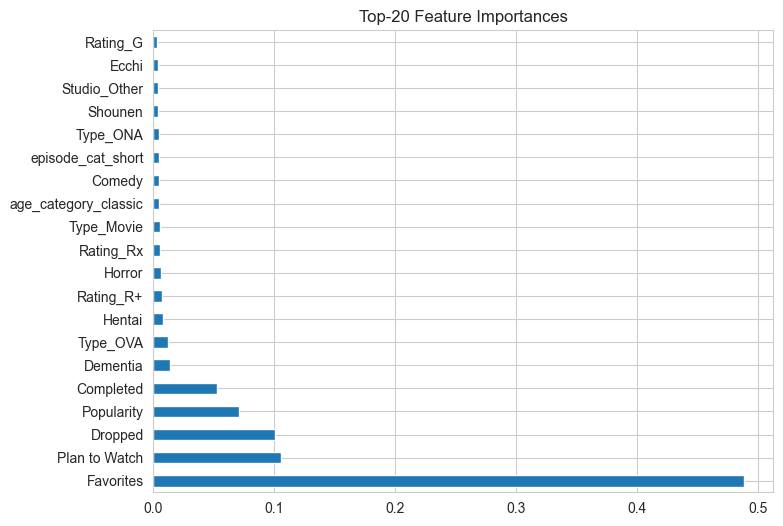

In [236]:
import matplotlib.pyplot as plt
import pandas as pd

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(20).plot(kind='barh', figsize=(8,6))
plt.title("Top-20 Feature Importances")
plt.show()

In [237]:
from sklearn.model_selection import cross_val_score
import numpy as np

scores = cross_val_score(model, X, y, cv=5, scoring='r2', n_jobs=-1)
print("R2:", scores)
print("Mean R2:", np.mean(scores))

R2: [0.67338457 0.69110303 0.73134474 0.77225121 0.57313933]
Mean R2: 0.6882445757921776
